This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds
import statstuff as sts

CUDA not available.


In [2]:
%matplotlib notebook

In [17]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments2'
imageroot = '20190702_case2.0'
Calibrationfile = '../Case2.0 (calibration)/Calibration.nml'

/Users/nesh/Documents/repositories/ice2019/crystals/2019-07-02/case2.0 (calibration)
2019-07-02/case2.0 (calibration)


In [18]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments2_retrieved.npz
Segments2_roughness.jpg
Segments2_roughness.txt


In [19]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [20]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/20190702_case2.0-A.bmp
SEMimages/20190702_case2.0-B.bmp
SEMimages/20190702_case2.0-C.bmp
SEMimages/20190702_case2.0-D.bmp
Filename, dx and dy SEMimages/20190702_case2.0-D.bmp 0.7632211 0.7632211


In [21]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 9.876285885143936
Correlation of detectors A-D for each segment
for segment  0
0 1 1.2946464652913185
0 2 -3.4560441010939122
0 3 -2.0380669856151923
1 2 2.748417865632492
1 3 -6.106710012438253
2 3 1.4562533108644782
Correlation score = 8.046144976459047



<IPython.core.display.Javascript object>


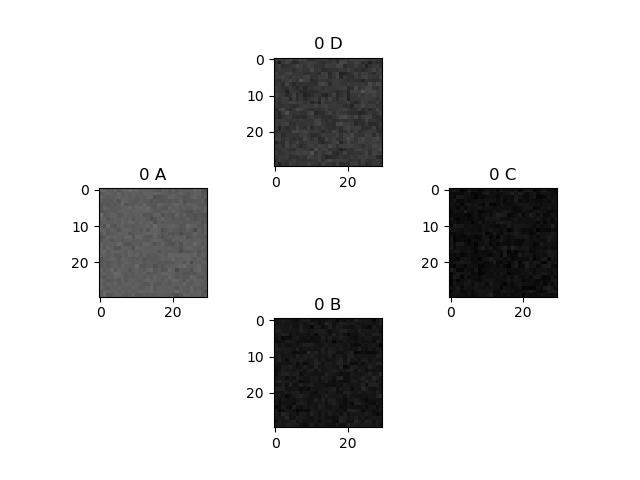

for segment  1
0 1 8.367059139144276
0 2 -6.6264400830217784
0 3 -6.951334399057554
1 2 -3.884452039766437
1 3 -7.553014046419112
2 3 -1.0241604041419181
Correlation score = 15.34354359681617



<IPython.core.display.Javascript object>


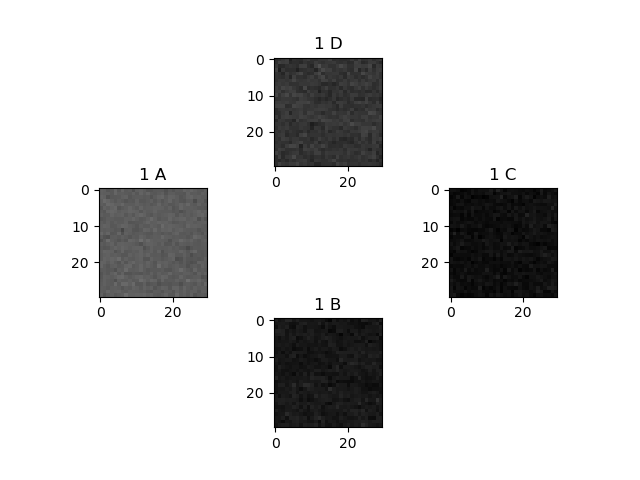

for segment  2
0 1 0.11647606093718524
0 2 -5.069244106574298
0 3 -8.718122155626633
1 2 3.399010391900496
1 3 -5.5852801869367905
2 3 0.45150118453470434
Correlation score = 12.027840044484718



<IPython.core.display.Javascript object>


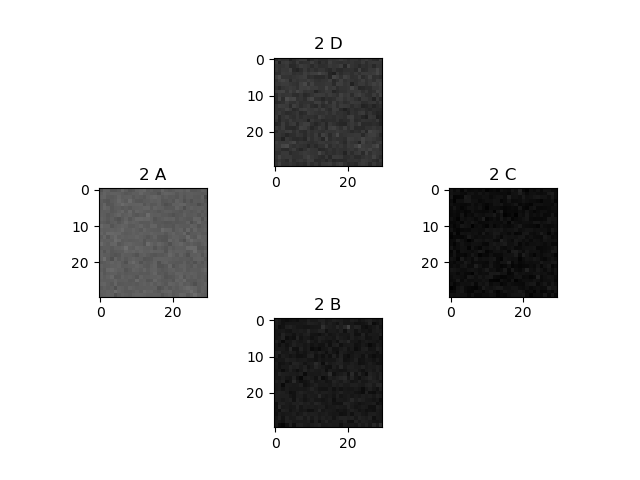

for segment  3
0 1 1.0850612794415107
0 2 -0.8072200784993492
0 3 -2.460874881652135
1 2 1.491968068369218
1 3 -4.732641749901329
2 3 1.681560357836397
Correlation score = 5.94444104230259



<IPython.core.display.Javascript object>


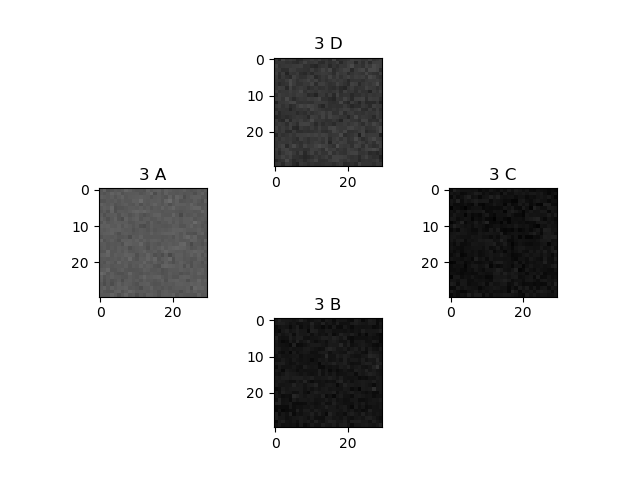

for segment  4
0 1 4.228390515368182
0 2 4.809629908535997
0 3 -2.6646688260992955
1 2 0.9846961369035873
1 3 -8.879814106972132
2 3 4.412825030904602
Correlation score = 12.141088747312462



<IPython.core.display.Javascript object>


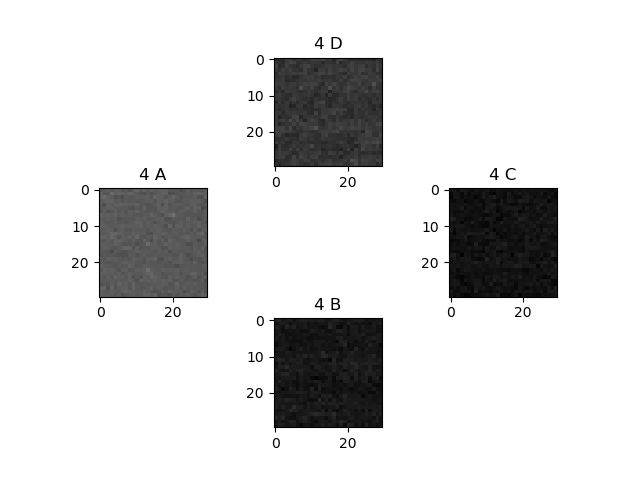

for segment  5
0 1 12.585056412139044
0 2 -3.041468129079481
0 3 -0.8971521628334385
1 2 0.08834006540949228
1 3 -19.49962252205071
2 3 6.373365877665911
Correlation score = 24.27554181394156



<IPython.core.display.Javascript object>


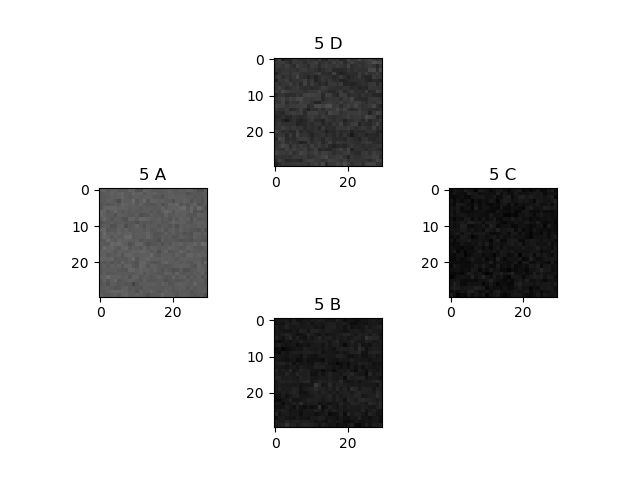

for segment  6
0 1 10.516496376577537
0 2 -10.22874548015771
0 3 -8.535399767444227
1 2 -0.7757063246225311
1 3 -26.848935329877964
2 3 1.3581109466831558
Correlation score = 31.802334714923546



<IPython.core.display.Javascript object>


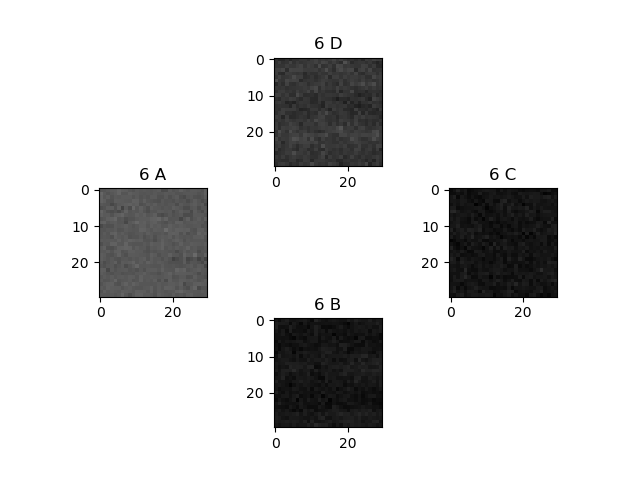

for segment  7
0 1 9.10750176491783
0 2 -2.680021940276467
0 3 -1.7019406695339734
1 2 -7.865654626892195
1 3 -5.196865215612359
2 3 5.539469608346098
Correlation score = 14.580375933477871



<IPython.core.display.Javascript object>


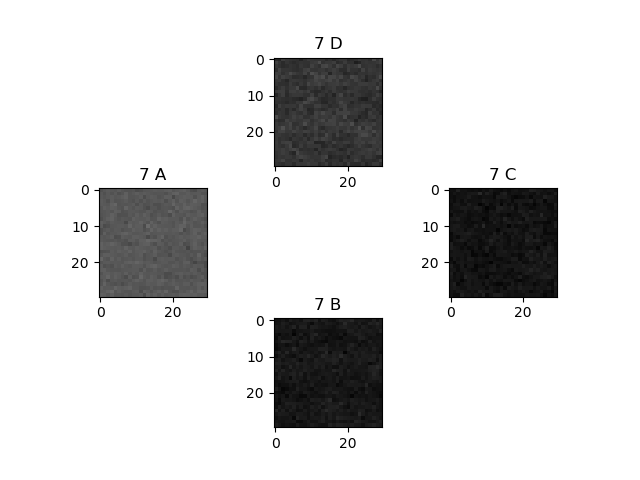

for segment  8
0 1 6.176446436789909
0 2 -4.478276647913667
0 3 -5.396434735193745
1 2 -5.691479483700718
1 3 -16.183090767164675
2 3 6.120337850871225
Correlation score = 20.471171463144774



<IPython.core.display.Javascript object>


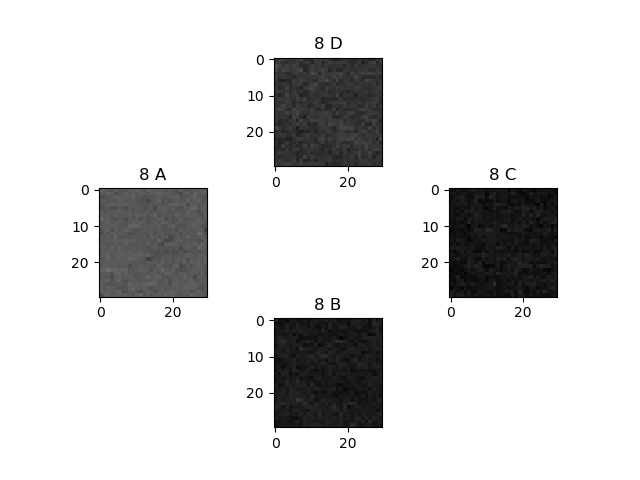

<IPython.core.display.Javascript object>


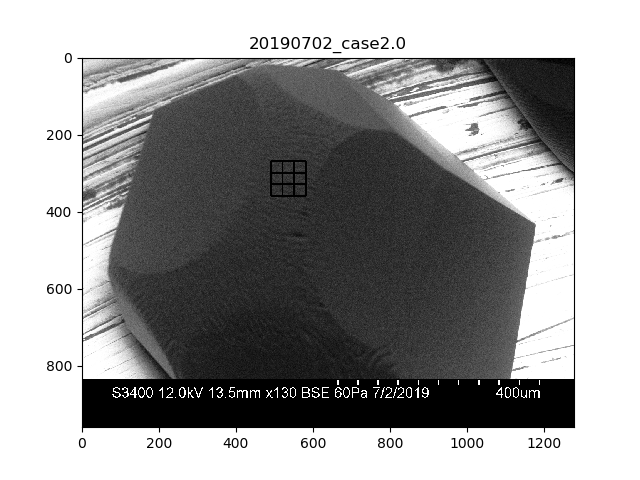

In [22]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [23]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

../Case2.0 (calibration)/Calibration.nml


In [24]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [25]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [26]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [27]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [28]:
# Generic retrieval parameters
maxiter = 4
tolerance = 10

In [29]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 10.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 3.1622776601683795
Std deviation in a priori is 15.0


In [30]:
# Loop to retrieve each segment
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    vartemp_long = np.reshape(vartemp,nzpts+1,0)
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = fbs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 9 )
for 490 270
Observed intensities (detector B):
mean, max, min = 19.506666666666668 36.0 5.0
<diff>, std(diff), di2 = 3.348865959747205 22.25540815730191 171321.07207978424
<diff>, std(diff), di2 = -2.0292681604361507 6.829655382597841 4444.3762848971555
<diff>, std(diff), di2 = -2.963048333564105 5.481904047100072 84.97635147280594
<diff>, std(diff), di2 = -3.083184070110685 5.389507386488069 1.6631312546499943

Segment: 1 ( 2 of 9 )
for 490 300
Observed intensities (detector B):
mean, max, min = 20.735555555555557 39.0 5.0
<diff>, std(diff), di2 = 3.295810404191648 21.823551574868613 164393.42643119846
<diff>, std(diff), di2 = -1.8486404746111853 6.731255608268459 4096.178134422979
<diff>, std(diff), di2 = -2.715583524304094 5.502290216842736 74.82699530657683
<diff>, std(diff), di2 = -2.823772970408335 5.424908115140905 1.1723140965480023
Noverlap = 31

Segment: 2 ( 3 of 9 )
for 490 330
Observed intensities (detector B):
mean, max, min = 22.02777777777778 52.0 

90
90


<IPython.core.display.Javascript object>


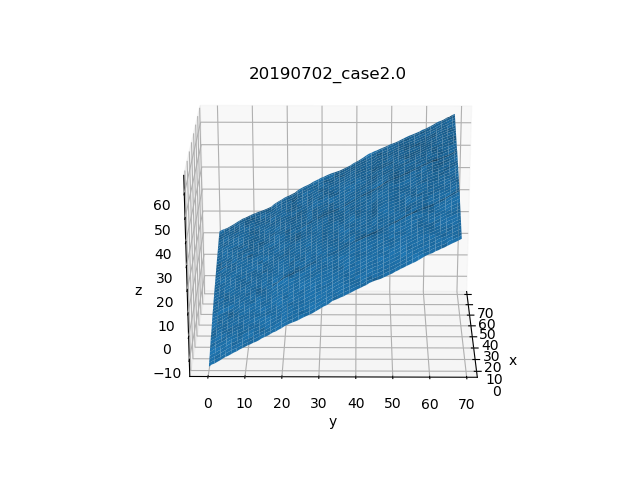

In [31]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [32]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments2_retrieved
